Fig. X: Title of the Analysis
----
Short description of what is being done here. 

# Preliminaries

## Dependecy notebooks

TODO: define here links to other notebooks which need to be run in the correct order prior
to running this notebook (e.g. data preprocessing/data generation).
If there aren't any, remove this section.

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.1 numba==0.51.0 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.1 seaborn==0.10.1


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [3]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [4]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [12]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "sample_notebook", separate_dirs=True)
except ImportError:
    c = None
    
use_caching = c is not None
c

Cache(root=/Users/marius/Projects/cellrank_reproducibility/cache/sample_notebook, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [6]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

Do we want to write figures?

In [7]:
save_figure = True

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

## Load the data

Load the AnnData object from the CellRank software package. 

In [8]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata

try downloading from url
https://ndownloader.figshare.com/files/25028786?private_link=bb68d6e4686df12a0e2a
... this may take a while but only happens once


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Main analysis part 1

Structure your analysis by sections and subsections. Often, the first part of the analysis will be about pre-processing the data and computing velocities. 

## Pre-process the data

Often, we want to process the raw data a bit differently than the data in `.X`.

### Raw data (for plotting)

In [9]:
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=10)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes, but don't filter them out
sc.pp.highly_variable_genes(adata_raw)
print(f"This detected {np.sum(adata_raw.var['highly_variable'])} highly variable genes. ")
adata.raw = adata_raw

filtered out 15011 genes that are detected in less than 10 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)
This detected 1480 highly variable genes. 


### Data for velocity computation

In [10]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Visualize annotations

Often, we want to show UMAP plots with cluster annotation of marker genes here.

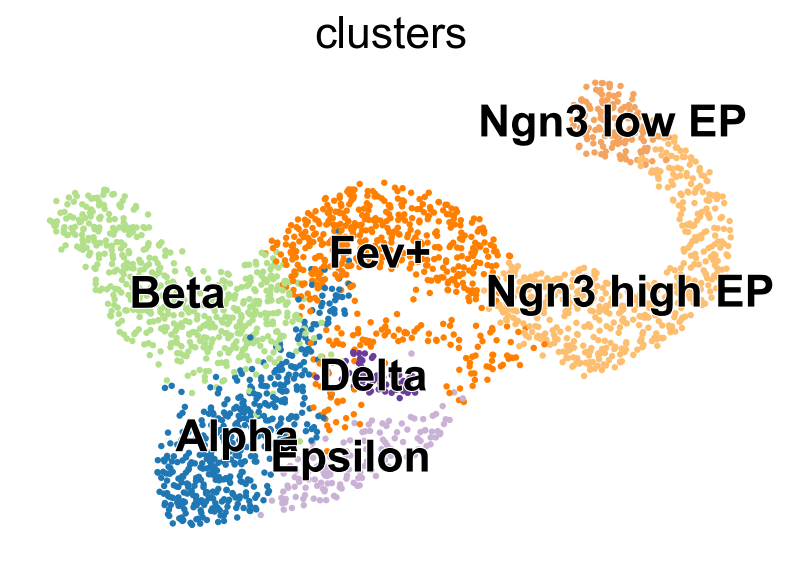

In [15]:
scv.pl.scatter(adata)

## Compute velocities using scVelo

In [13]:
# compute/load from cache the dyn. model params and compute velocities
if use_caching:
    c.tl.recover_dynamics(adata, fname='recover_dynamics', force=False)
else:
    scv.tl.recover_dynamics(adata)
    
scv.tl.velocity(adata, mode='dynamical')

No cache found in `recover_dynamics.pickle`, computing values.
recovering dynamics
    finished (0:07:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Often, we want to show velocities in the UMAP embedding here.

computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


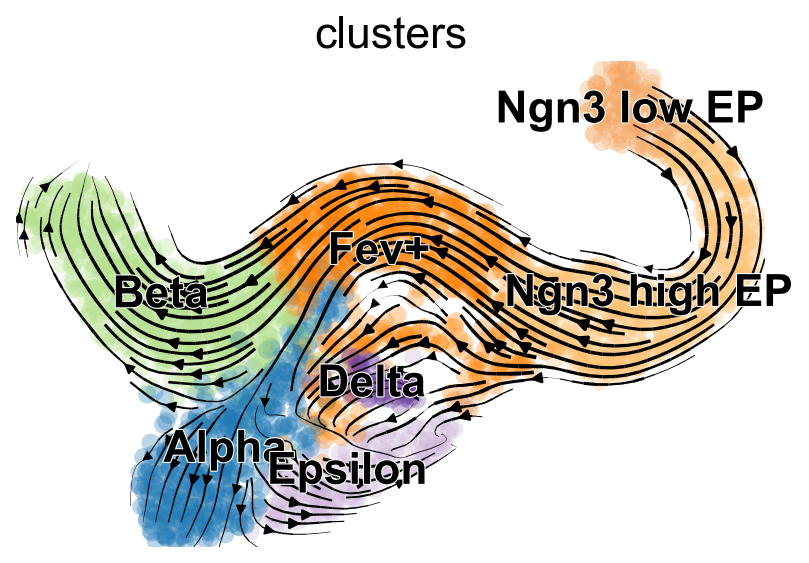

In [18]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata)

# Main analysis part 2

Typically, the second part of the analysis will involve CellRank. 